In [22]:
#TODO: create customed anno, anno_dict from raw csv
#input is csv annotation file
#output is anno, anno_dict

import pandas as pd
import cv2
import numpy as np
import glob
import os
import pickle

import namespace
import log_parser
import youtubebb_converter
import imagenet_converter
import dataset_generator
import metric_map
import predictor2
import utils


from matplotlib import pyplot as plt
%matplotlib inline



def plot_bbox(rgb_img, pred_item, color_idx=0):
    _, cid, score, xmin, ymin, xmax, ymax = pred_item
    cname = namespace.CLASS_INDEX[cid]
    
    scale = np.array(rgb_img.shape[1::-1]+rgb_img.shape[1::-1])#[1::-1])
    label_name = cname
    display_txt = '%s: %.2f'%(label_name, score)
    detection = np.array([xmin, ymin, xmax, ymax])
    pt = detection * scale#(detection*scale).cpu().numpy()
    coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
    
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    color = colors[0]

    plt.imshow(rgb_img)
    
    if len(pred_item) > 0:
        currentAxis = plt.gca()
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    plt.axis('off')
    plt.figure()
    
def get_groundtruth_item(img_filepath, vid_filepath, pred):
    #TODO: 
    img = cv2.imread(img_filepath, cv2.IMREAD_COLOR)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    dtoken, ftoken = utils.get_dirtoken_from_vidpath(vid_filepath), utils.get_filetoken_from_imgpath(vid_filepath, img_filepath)
    gt_list = yanno_dict[dtoken][ftoken]
    
    pred_list = pred.detect(img)
    if pred_list == []:
        #print ('DETECTED NOTHING for {}, SKIPPED'.format(img_filepath))
        return 0.0#gt_list[0], pred_list, 0.0
    #plot_bbox(rgb_img, pred_list[0])
    #plot_bbox(rgb_img, gt_list[0], color_idx=10)

    score = mAP.score(pred_list, gt_list)
    return score#gt_list[0], pred_list, score

def get_all_frameversions(frame_filepath, vid_filepath, pred):
    #TODO: for a given frame in max bitrate & max resolution (x1080_b1024), 
    #retrive corresponding frames in other bitrates & resolutions
    #INPUT: a filepath to frame in highest res & bit
    #OUTPUT: grouthtruth for everyone
    
    frame_filemask = frame_filepath.replace(namespace.FRAMEVERSION_BEST, '*')
    result = []
    for img_filepath in glob.glob(frame_filemask):
        result.append(get_groundtruth_item(img_filepath, vid_filepath, pred))
    return result

def generate_viditem_groundtruth(vidpath, pred):
    #TODO: generate ground truth from given video path
    #INPUT: path to video, predictor
    #OUTPUT: dict structure store groundtruth all frames for that video
    result = {}
    framemask = os.path.splitext(vidpath)[0] + '/' + namespace.FRAMEVERSION_BEST + '/??????.jpg'
    for framepath in glob.glob(framemask): #go over all frame item in the best verion
        #for each best frame item, collect score over all of its versions
        #print item
        try:
            gt_list = get_all_frameversions(framepath, vidpath, pred)
        except:
            print ('ERROR: ', framepath, vidpath)
            raise
        result[framepath] = gt_list
    return vidpath, result

In [23]:
#in order for log_parser to work, previous steps are assumed to be taken.
#see https://github.com/phananh1010/content-aware/tree/master/scripts for further detail

LogParser = log_parser.LogParser()
vidinfo_dict= LogParser.load_metainfo_dict()

YConverter = youtubebb_converter.YoutubeBBConverter(vidinfo_dict)
mAP = metric_map.mAP()
#Pred  = predictor.Predictor()
pred300 = predictor2.Predictor('300')
pred512 = predictor2.Predictor('512')

#only run once to create processed Youtube annotation dict, write to FILEPATH_YOUTUBE_YANNODICT
YConverter.parse_annotation(namespace.FILEPATH_YOUTUBE_RAWANNOCSV, namespace.FILEPATH_YOUTUBE_YANNODICT)
yanno, yanno_dict = YConverter.load_annotation(namespace.FILEPATH_YOUTUBE_YANNODICT)

#DATGEN nolong used
#DatGen = dataset_generator.DatasetGenerator(YConverter, mAP, Pred, yanno_dict)

#for debuging purpose only
#df = pd.DataFrame.from_csv('./data/YOUTUBE_data/yt_bb_detection_train.csv', header=None)
df = pd.read_csv('./data/YOUTUBE_data/yt_bb_detection_train.csv', header=None)
df1 = pd.read_pickle('./data/YOUTUBE_data/yt_bb_detection_train_filtered.pkl.gz', compression='gzip')
                            #./data/YOUTUBE_data/yt_bb_detection_train_filtered.csv


In [24]:
#TODO
#from ID=15, list all videos (use bash to generate)
#from videos list, call python code to generate groundtruth

#the python code: receive a filepath to the videos, iterate over images
#ID = 15
#PYTHON CODE
#INPUT: filepath to video
#OUTPUT: ground truth array for every single frame


In [25]:
namespace.DIRPATH_YOUTUBE_VIDEOS, GROUNDTRUTH_DICT_FILEPATH

('/home/u9167/content_aware/data/YOUTUBE_data/videos',
 '/home/u9167/content_aware/data/YOUTUBE_data/_groundtruth_dict_0_')

In [ ]:
ID = 0

_GROUNDTRUTH_DICT_TEMPLATE_ = namespace.GROUNDTRUTH_DICT_TEMPLATE
GROUNDTRUTH_DICT_FILEPATH = _GROUNDTRUTH_DICT_TEMPLATE_.format(ID)
vidmask = namespace.DIRPATH_YOUTUBE_VIDEOS + '/{}/'.format(ID) + '*.mp4'

gt_dict = {}
try:
    gt_dict = pickle.load(open(GROUNDTRUTH_DICT_FILEPATH, 'rb'))
except Exception as ex:
    print ('ERROR, no file found, will use default empty dic, {}'.format(ex))
    

for vid_filepath in glob.glob(vidmask):
    if vid_filepath in gt_dict: 
        print ("SKIPPED {}".format(vid_filepath))
        continue
    print ('processing {}'.format(vid_filepath))
    try:
        k300, v300 = generate_viditem_groundtruth(vid_filepath, pred300)
        k512, v512 = generate_viditem_groundtruth(vid_filepath, pred512)
        gt_dict[k] = (v300, v512)
        
        if k300 != k512: 
            raise
        pickle.dump(gt_dict, open(GROUNDTRUTH_DICT_FILEPATH, 'wb'))
    except Exception as ex: 
        print ("SKIPPED {} EXCEPTION: {}".format(vid_filepath, ex))
        continue
    

ERROR, no file found, will use default empty dic, [Errno 2] No such file or directory: '/home/u9167/content_aware/data/YOUTUBE_data/_groundtruth_dict_0_'
processing /home/u9167/content_aware/data/YOUTUBE_data/videos/0/-0FIw1zUzMo+0+0.mp4


In [6]:
pickle.dump(gt_dict, open(GROUNDTRUTH_DICT_FILEPATH, 'w'))

In [ ]:
#####################END OF EXAMPLE USAGE#######

In [ ]:
#####################DEBUGGING PART###############

In [4]:
vidpath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0.mp4'

#given video, output frames

framemask = os.path.splitext(vidpath)[0] + '/' + namespace.FRAMEVERSION_BEST + '/*.jpg'
for item in glob.glob(framemask):
    print item
#framemask_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0.mp4'



/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000001.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000002.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000003.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000004.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000005.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000006.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000007.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000008.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000009.jpg
/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000010.jpg


[1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 1.0,
 0.1,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.1,
 0.1,
 0.0,
 0.0,
 0.0,
 1.0,
 0.1,
 0.1,
 0.1,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.1,
 0.1,
 0.0]

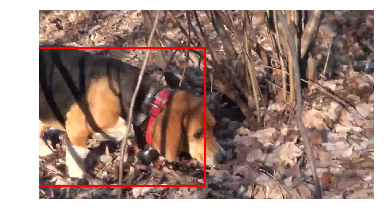

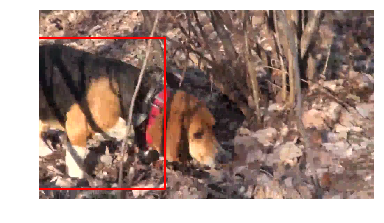

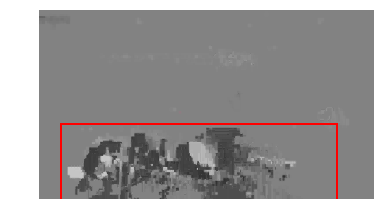

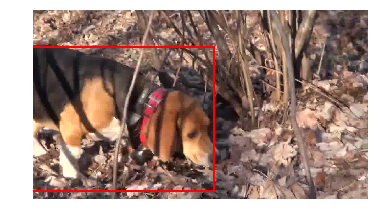

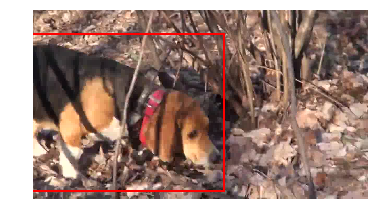

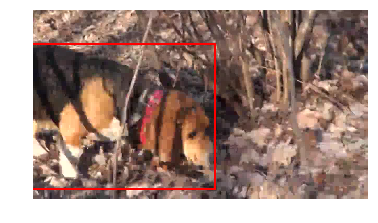

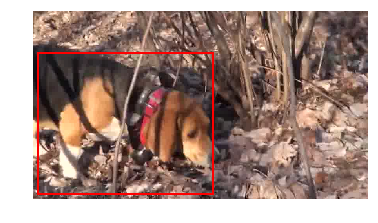

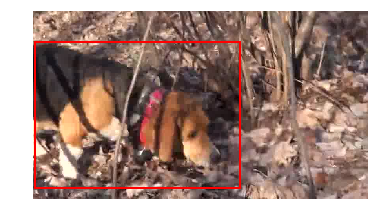

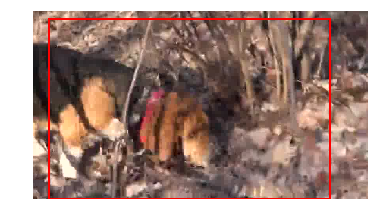

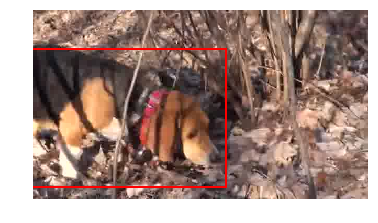

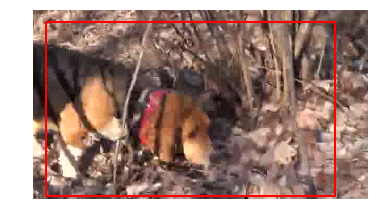

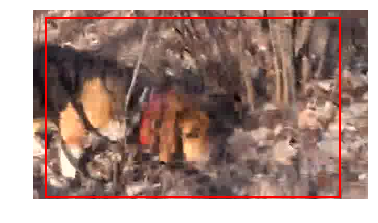

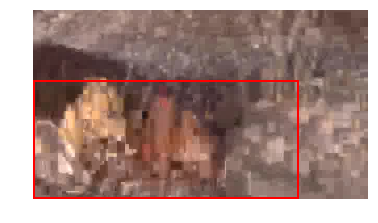

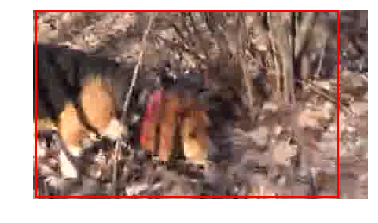

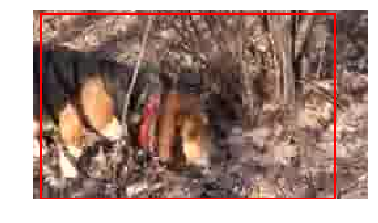

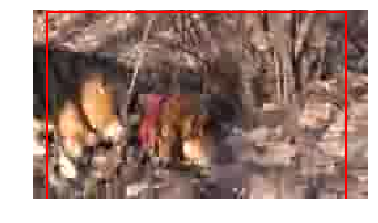

<Figure size 432x288 with 0 Axes>

In [15]:
frame_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0/frames_x1080_b1024k/000003.jpg'
vid_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/1/7sq8O2KpCf0+1+0.mp4'

vid_filepath = './data/YOUTUBE_data/videos/15/7m_Fvo-uWK8+15+0.mp4'
frame_filepath = './data/YOUTUBE_data/videos/15/7m_Fvo-uWK8+15+0/frames_x1080_b1024k/000003.jpg'

frame_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/10/8q0FNaWFBjw+10+0/frames_x1080_b1024k/000005.jpg'
vid_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/10/8q0FNaWFBjw+10+0/'

frame_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/19/ShDBzVI0_Io+19+0/frames_x1080_b1024k/000005.jpg'
vid_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/19/ShDBzVI0_Io+19+0.mp4'


#given framepath & vidpath, generate groundtruth
get_all_frameversions(frame_filepath, vid_filepath, Pred)

In [13]:
img_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/15/4Ht9Cn1u9sw+15+0/frames_x1080_b1024k/10000001.jpg'
vid_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/15/4Ht9Cn1u9sw+15+0.mp4'

img_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/7/0sGUOpJZfKc+7+0/frames_x1080_b1024k/000003.jpg'
vid_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/7/0sGUOpJZfKc+7+0.mp4'

img_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/7/7-nbbwqZHOw+7+0/frames_x1080_b1024k/000012.jpg'
vid_filepath = '/home/u9167/content_aware/data/YOUTUBE_data/videos/7/7-nbbwqZHOw+7+0.mp4'

dtoken= utils.get_dirtoken_from_vidpath(vid_filepath)
ftoken= utils.get_filetoken_from_imgpath(vid_filepath, img_filepath)

In [14]:
yanno_dict[dtoken][ftoken]

KeyError: '7-nbbwqZHOw+6+0+12'

In [15]:
yanno_dict[dtoken]

{'7-nbbwqZHOw+6+0+0': [(0.0, 6, 1.0, 0.322, 0.0, 0.9470000000000001, 0.93)],
 '7-nbbwqZHOw+6+0+1': [(0.0, 6, 1.0, 0.386, 0.06333333, 0.746, 0.735)],
 '7-nbbwqZHOw+6+0+10': [(0.0,
   6,
   1.0,
   0.435,
   0.34833333,
   0.8140000000000001,
   0.785)],
 '7-nbbwqZHOw+6+0+11': [(0.0,
   6,
   1.0,
   0.499,
   0.18833333,
   0.9209999999999999,
   0.8516667)],
 '7-nbbwqZHOw+6+0+13': [(0.0, 6, 1.0, 0.449, 0.40166667, 1.0, 1.0)],
 '7-nbbwqZHOw+6+0+14': [(0.0, 6, 1.0, 0.0, 0.63166666, 0.305, 1.0)],
 '7-nbbwqZHOw+6+0+2': [(0.0,
   6,
   1.0,
   0.439,
   0.22333333,
   0.897,
   0.7816666999999999)],
 '7-nbbwqZHOw+6+0+3': [(0.0,
   6,
   1.0,
   0.41100000000000003,
   0.42166665,
   0.693,
   1.0)],
 '7-nbbwqZHOw+6+0+4': [(0.0, 6, 1.0, 0.386, 0.42166665, 0.794, 1.0)],
 '7-nbbwqZHOw+6+0+5': [(0.0,
   6,
   1.0,
   0.391,
   0.42666668,
   0.8390000000000001,
   0.98333335)],
 '7-nbbwqZHOw+6+0+6': [(0.0,
   6,
   1.0,
   0.35700000000000004,
   0.35,
   0.8690000000000001,
   0.96333330000000

In [10]:
ID_LIST = [1, 7, 10, 15, 19]

num_img = 0
num_vid = 0
for ID in ID_LIST:
    _GROUNDTRUTH_DICT_TEMPLATE_ = namespace.DIRPATH_YOUTUBE_DATA + '/' + '_groundtruth_dict_{}_'
    GROUNDTRUTH_DICT_FILEPATH = _GROUNDTRUTH_DICT_TEMPLATE_.format(ID)
    vidmask = namespace.DIRPATH_YOUTUBE_VIDEOS + '/{}/'.format(ID) + '*.mp4'

    gt_dict = pickle.load(open(GROUNDTRUTH_DICT_FILEPATH))
    num_vid += len(gt_dict)
    for k in gt_dict:
        num_img += len(gt_dict[k])
print num_img
print num_vid

2195
127


In [6]:
namespace.FILEPATH_YOUTUBE_YANNODICT

'/home/u9167/content_aware/data/YOUTUBE_data/yanno_dict'

In [9]:
df

,0,1,2,3,4,5,6,7,8,9
0,AAB6lO-XiKE,238000,0,person,0,present,0.482,0.540,0.371667,0.616667
1,AAB6lO-XiKE,239000,0,person,0,present,0.514,0.588,0.363333,0.606667
2,AAB6lO-XiKE,240000,0,person,0,present,0.534,0.614,0.443333,0.685000
3,AAB6lO-XiKE,241000,0,person,0,present,0.515,0.605,0.448333,0.686667
4,AAB6lO-XiKE,242000,0,person,0,present,0.550,0.600,0.400000,0.638333
...,...,...,...,...,...,...,...,...,...,...
5608007,__909tIOxbc,12000,0,person,0,present,0.845,0.979,0.276667,0.885000
5608008,__909tIOxbc,13000,0,person,0,present,0.842,0.973,0.266667,0.875000
5608009,__909tIOxbc,14000,0,person,0,present,0.835,0.965,0.246667,0.850000
5608010,__909tIOxbc,15000,0,person,0,present,0.630,0.756,0.343333,0.925000
